<font size="4">  
    ML 5622 Final Project - Laptop Prices
</font> 
<font size="3">  
    <ul>
        <li>Dataset is taken from <a href="https://www.kaggle.com/datasets/owm4096/laptop-prices" target="_blank">Kaggle</a></li>  
    </ul>
</font> 
<font size="2"> 
    For complete analysis and write up please consult the <b>README</b>
</font>

In [186]:
# import libraries used from previous assignments
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

In [187]:
# connect to Kaggle dataset and display contents
df = pd.read_csv('laptop_prices.csv')
df.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [188]:
## Data Cleaning
# remove Apple products
company_index = df[(df.Company == 'Apple')].index
df = df.drop(company_index)
# remove default Intel graphics
intel_graphics_index = df[(df.GPU_company == 'Intel')].index
df = df.drop(intel_graphics_index)
# remove unnecessary features / features I don't care about
df = df.drop(columns=['TypeName','Touchscreen','IPSpanel','RetinaDisplay','ScreenW','ScreenH'])
# rename price
df = df.rename(columns={'Price_euros': 'Price'})
# count how many rows actually have secondary storage, we can possibly remove this feature
secondary_storage_value_counts = df['SecondaryStorage'].value_counts()
print('secondary_storage_value_counts: ', secondary_storage_value_counts)
# remove secondary storage - too few laptops actually have secondary storage
df = df.drop(columns=['SecondaryStorage','SecondaryStorageType'])

# visually inspect cleaned data for oddities
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(df)


secondary_storage_value_counts:  SecondaryStorage
0       369
1024    182
2048     15
500       1
256       1
Name: count, dtype: int64


In [189]:
## EDA
# remove non numeric columns for heatmap
dfNumericFeatures = df[['Price', 'Inches', 'Ram', 'Weight', 'CPU_freq', 'PrimaryStorage']]
dfNumericFeatures.corr()

,Price,Inches,Ram,Weight,CPU_freq,PrimaryStorage
Price,1.000000,0.295449,0.758288,0.509455,0.386945,-0.186380
Inches,0.295449,1.000000,0.290736,0.727694,0.066919,0.039541
Ram,0.758288,0.290736,1.000000,0.511122,0.300644,-0.084353
Weight,0.509455,0.727694,0.511122,1.000000,0.227495,-0.029567
CPU_freq,0.386945,0.066919,0.300644,0.227495,1.000000,-0.057229
PrimaryStorage,-0.186380,0.039541,-0.084353,-0.029567,-0.057229,1.000000


<Axes: >

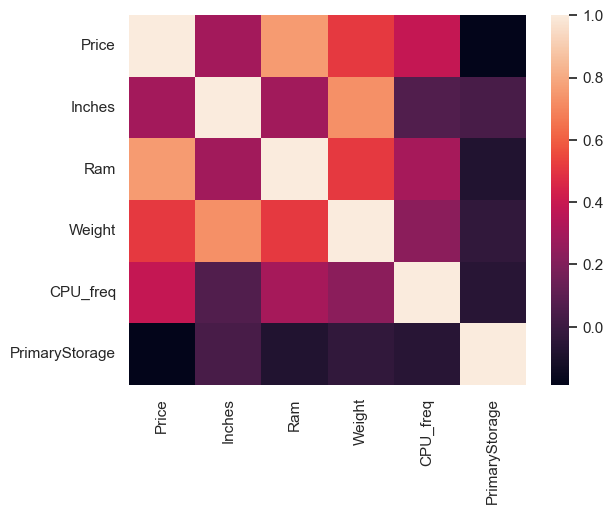

In [190]:
# visualizing coorelation matrix
sns.heatmap(dfNumericFeatures.corr())

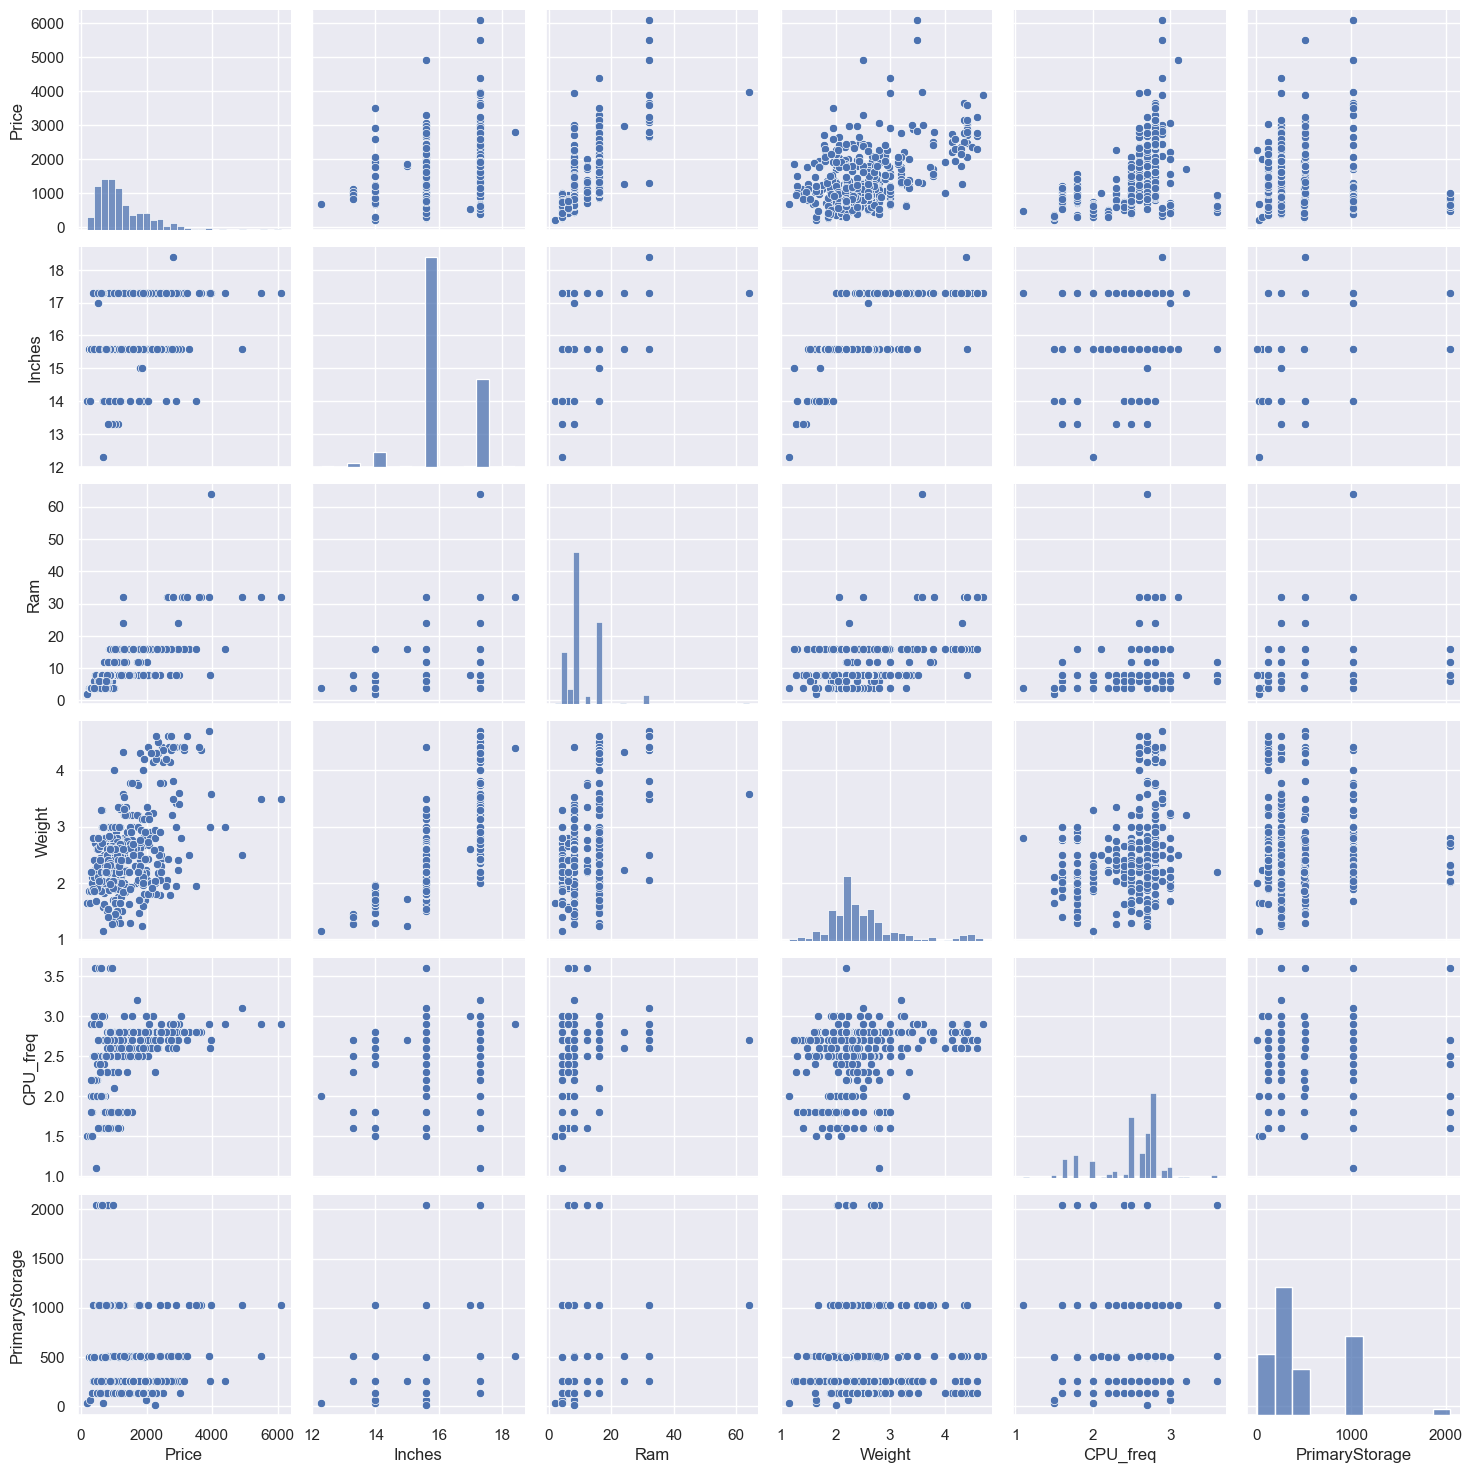

In [191]:
# inspecting relationships between features
dfNumericFeatures = dfNumericFeatures.apply(lambda x: pd.to_numeric(x, errors='coerce'))
sns.pairplot(dfNumericFeatures)
plt.show()

In [192]:
## Models
# starting with a simple linear regression model
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42) # get training data

model_weight = smf.ols(formula='Price ~ Weight', data=X_train).fit().rsquared_adj
model_inches = smf.ols(formula='Price ~ Inches', data=X_train).fit().rsquared_adj
model_ram = smf.ols(formula='Price ~ Ram', data=X_train).fit().rsquared_adj
model_cpu_freq = smf.ols(formula='Price ~ CPU_freq', data=X_train).fit().rsquared_adj
model_primary_storage = smf.ols(formula='Price ~ PrimaryStorage', data=X_train).fit().rsquared_adj

best_predictors = [['Weight:', model_weight], ['Inches:', model_inches], ['RAM:', model_ram], ['CPU Freq:', model_cpu_freq], ['Primary Storage:', model_primary_storage]]
best_predictors.sort(key = lambda x : x[1], reverse=True)

# top predictors
for best_predictor in best_predictors:
    print(best_predictor[0], best_predictor[1])



RAM: 0.6034305447934012
Weight: 0.2632708906694272
CPU Freq: 0.15270625011023686
Inches: 0.08011698902683262
Primary Storage: 0.026898235836482542


In [193]:
# multi-linear regression model of top 3 best predictors
model_multi = smf.ols('Price ~ Ram + Weight + CPU_freq', data=X_train).fit() 
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     277.6
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          5.91e-102
Time:                        21:29:57   Log-Likelihood:                -3444.4
No. Observations:                 454   AIC:                             6897.
Df Residuals:                     450   BIC:                             6913.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -871.0892    156.197     -5.577      0.0

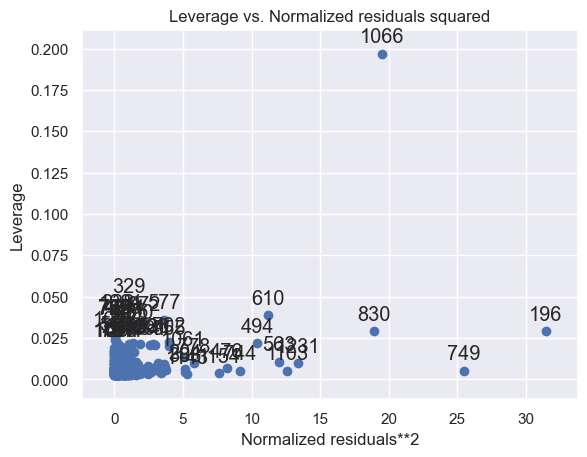

In [194]:
# plot the leverage vs. the square of the residual
sm.graphics.plot_leverage_resid2(model_multi)
plt.show()

In [195]:
# visually see data with the following uncommented
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(df)

# list of indices for high-leverage and/or high-residual points
unusual = [1066,196,1136,749,830,901,610,341,247,1240,591,702,982]
df = df.drop(unusual)[['Price', 'Ram', 'Weight', 'CPU_freq']]
formula = 'Price ~ Ram + Weight + CPU_freq'
model_final = smf.ols(formula, data=df).fit()
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     339.5
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          8.53e-125
Time:                        21:29:57   Log-Likelihood:                -4131.7
No. Observations:                 555   AIC:                             8271.
Df Residuals:                     551   BIC:                             8289.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -770.9591    121.166     -6.363      0.0

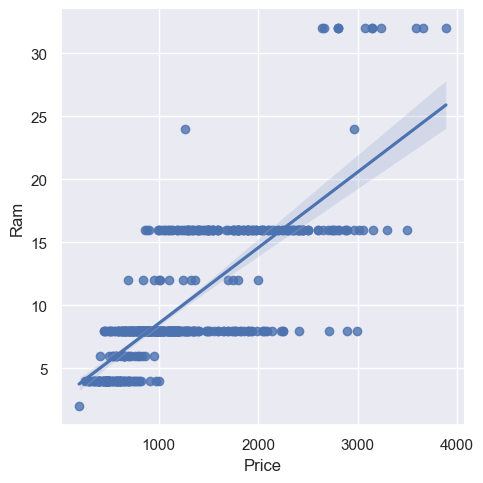

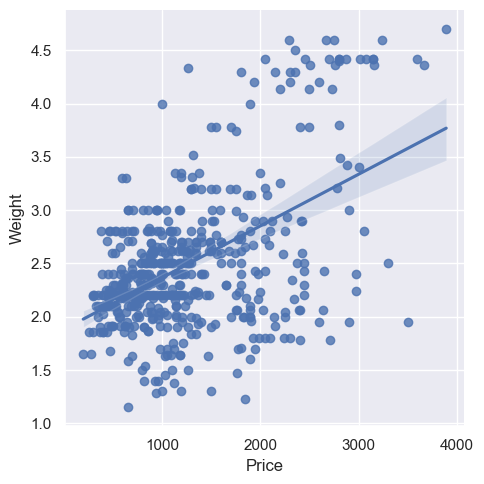

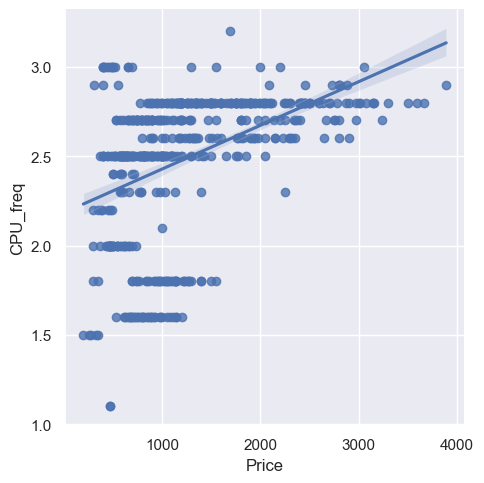

In [196]:
# plot regression model against features
sns.lmplot(x='Price',  y='Ram', data=df, fit_reg=True) 
plt.show()
sns.lmplot(x='Price',  y='Weight', data=df, fit_reg=True) 
plt.show()
sns.lmplot(x='Price',  y='CPU_freq', data=df, fit_reg=True) 
plt.show()

In [197]:
# cross validation using KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
 
X = dfNumericFeatures.iloc[:,:-1]
y = dfNumericFeatures.iloc[:,-1]
kf = KFold(n_splits=5, random_state=None) # split data into 5 subsets
model = LogisticRegression(solver='liblinear') 
result = cross_val_score(model,X,y,cv=kf)
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.4189877348237851


Visual Representation of K-Fold Cross Validation

![alt text](K-Fold.jpg)